# Loading data

In [1]:
import numpy as np
import hicstraw

In [2]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# hic = hicstraw.HiCFile("https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic")

In [3]:
hic = hicstraw.HiCFile("inter_30.hic")

In [4]:
RESOLUTION = 50000

In [5]:
mzd = hic.getMatrixZoomData(
    "4", "4", "observed", "KR", "BP", RESOLUTION
) 

In [6]:
numpy_matrix_chr4 = mzd.getRecordsAsMatrix(0, 8000000, 0, 8000000)

In [7]:
numpy_matrix_chr4

array([[0.00000000e+00, 1.47791077e+02, 2.54276596e+02, ...,
        0.00000000e+00, 8.35659409e+01, 4.69745026e+01],
       [1.47791077e+02, 1.54102625e+03, 2.91482361e+02, ...,
        0.00000000e+00, 4.70151281e+00, 2.64283776e+00],
       [2.54276596e+02, 2.91482361e+02, 1.18260034e+03, ...,
        2.53686118e+00, 0.00000000e+00, 1.70513952e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.53686118e+00, ...,
        9.37105652e+02, 2.70124908e+02, 9.37308426e+01],
       [8.35659409e+01, 4.70151281e+00, 0.00000000e+00, ...,
        2.70124908e+02, 1.71466174e+03, 1.65872574e+02],
       [4.69745026e+01, 2.64283776e+00, 1.70513952e+00, ...,
        9.37308426e+01, 1.65872574e+02, 1.14157361e+03]])

In [8]:
numpy_matrix_chr4.shape

(161, 161)

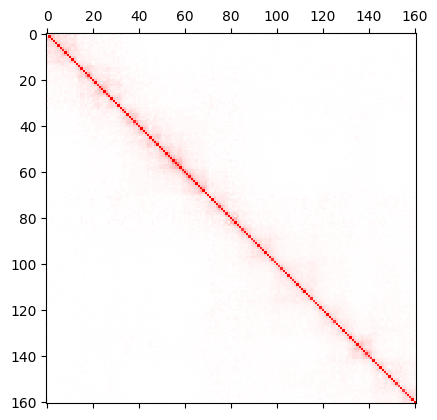

In [9]:
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])


# helper function for plotting
def plot_hic_map(dense_matrix, maxcolor, tads = None):
    # TAD communities and matrix must be on the same resolution, otherwise it wont work
    fig, ax = plt.subplots()
    ax.matshow(dense_matrix, cmap=REDMAP, vmin=0, vmax=maxcolor)
    if tads:
        for tad in tads:
            rect = patches.Rectangle((tad[0], tad[0]), len(tad), len(tad), linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
plt.show()


plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2)

In [58]:
import juicebox_notebook

In [59]:
juicebox_notebook.init()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
b = juicebox_notebook.Browser(
    {  # load hic via URL
        "name": "GM12878",
        #"locus": "2:3,319,567-30,009,566",
        "url": "https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic",
        "normalization": "KR",
    }
)

<IPython.core.display.Javascript object>

# Arrowhead

In [16]:
# java -jar juicer_tools_1.22.01.jar arrowhead <options, eg: > -k NONE -r 5000 hic_data/inter_30.hic test --ignore-sparsity

## Links

[Main juicer repo (git clone)](https://github.com/aidenlab/juicer)   
[Arrowhead jar download](https://github.com/aidenlab/juicer/wiki/Download)   
[Arrowhead use instruction](https://github.com/aidenlab/juicer/wiki/Arrowhead)  

# Algorithm

In [10]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

In [11]:
import random
import copy
import multiprocessing as mp


class ModLouvien:
    def __init__(self, A, gamma, N = 100,  eps=1e-10, seed=None):
        self.A = A
        self.gamma = gamma
        self.N = N # number of times to run the algorithm
        self.classes = [
            i for i in range(len(A))
        ]  # communities assignments, at first -- each node to different community
        self.eps = eps  # for stopping condition

        if seed:
            random.seed(seed)

    def run(self, verbose=False):
        # main function to use "outside" -- algorithm is run N times, and then aggregated -- https://www.biorxiv.org/content/10.1101/089011v1.full
        # remade with multiprocessing
        self.N_communities = []
        self.N_communities_indexes = []
        pool = mp.Pool()
        for i in range(self.N):
            if verbose:
                print(f"Algorithm run {i+1}...")
            pool.apply_async(self._run_algorithm, args=(verbose,), callback=self.append_communities)
        pool.close()
        pool.join()
        best_index = self.aggregate_results(self.N_communities_indexes)
        return self.N_communities[best_index]
    
    def append_communities(self, result):
        self.N_communities.append(result[0])
        self.N_communities_indexes.append(result[1])

    def aggregate_results(self, communities):
        num_comm = len(communities)
        pairwise_rand = np.zeros((num_comm,num_comm))
    
        for i in range(num_comm):
        	for j in range(num_comm):
        		pairwise_rand[i,j] = adjusted_rand_score(communities[i], communities[j])
    
        avg_pairwise_rand = np.average(pairwise_rand, axis = 0)
    
        idx = np.argmax(avg_pairwise_rand)
    
        return idx

    def community_to_indexes(self, community):
        # transform community lists to indexes (each element gest community index)
        idxes = []
        for i in range(len(community)):
            idxes.extend([i for _ in range(len(community[i]))])
        return idxes

    def _run_algorithm(self, verbose):
        # main algorithm function, implements version from https://www.biorxiv.org/content/10.1101/089011v1.full
        A, classes = self.A, self.classes
        rowsum = np.sum(A, axis=1)
        rowcolsums = np.outer(
            rowsum, rowsum
        ) # matrix witk k_ik_j, for speeding up Q computation
        communities = [[i] for i in range(len(self.classes))]  # final communities
          
        Q_prev = -1
        Q_curr = self.compute_Q(A, classes, rowcolsums)
        while Q_curr - Q_prev > self.eps:
            Q_prev = Q_curr
            rand_idx = list(
                range(len(classes))
            )  # We permute indexes randomly each time
            random.shuffle(rand_idx)
            for i in rand_idx:
                # switching left/right neighbour and comparing if Q increased
                i_left = max(0, i - 1)
                i_right = min(len(rand_idx) - 1, i + 1)

                classes_left = copy.copy(classes)
                classes_left[i_left] = classes_left[i]
                classes_right = copy.copy(classes)
                classes_right[i_right] = classes_right[i]

                Q_left = self.compute_Q(A, classes_left, rowcolsums)
                Q_right = self.compute_Q(A, classes_right, rowcolsums)
                Q_max = max(Q_curr, Q_left, Q_right)
                if Q_max == Q_left:
                    classes = classes_left
                    Q_curr = Q_left
                if Q_max == Q_right:
                    classes = classes_right
                    Q_curr = Q_right

            A, classes, rowcolsums, communities = self.consolidate_communities(A, classes, communities)
            if len(classes) <= 1:
                break
            if verbose:
                print(f"Current Q: {Q_curr}")
                print(f"Prev Q: {Q_prev}")
                print("-------------------------")
        commmunity_idxes = self.community_to_indexes(communities)
        return communities, commmunity_idxes

    def consolidate_communities(self, A, classes, communities):
        # Communities consolidation - we recalculate A and classes so that we get A and classes for new communities
        new_classes = []
        indices = []
        curr_indices = []
        # creating new_classes
        for i in range(1, len(classes)):
            curr_indices.append(i - 1)
            if classes[i - 1] != classes[i]:
                new_classes.append(classes[i - 1])
                indices.append(curr_indices)
                curr_indices = []
        curr_indices.append(len(classes) - 1)
        indices.append(curr_indices)
        new_classes.append(len(classes) - 1)

        new_A = np.zeros((len(new_classes), len(new_classes)))
        for i in range(len(indices)):
            for j in range(len(indices)):
                for k in indices[i]:
                    for l in indices[j]:
                        new_A[i, j] += A[k, l]
        rowsum = np.sum(new_A, axis=1)
        rowcolsums = np.outer(rowsum, rowsum)
        communities = self.update_global_communities(indices, communities)
        return new_A, new_classes, rowcolsums, communities

    def update_global_communities(self, indices, communities):
        # updating global communities assignments
        new_communities = [[] for _ in range(len(indices))]
        for i in range(len(indices)):
            for j in indices[i]:
                new_communities[i] += communities[j]

        return new_communities

    def compute_Q(self, A, classes, rowcolsums):
        # Q computation from the formula from article -- using numpy einsum for faster computation
        Q = 0
        m = np.sum(A)
        delta = np.equal.outer(classes, classes)
        Q = np.sum((A - self.gamma * rowcolsums / m) * delta)
        return Q / m

In [79]:
lv = ModLouvien(numpy_matrix_chr4, 1.5)

In [80]:
communities = lv.run(verbose=False)

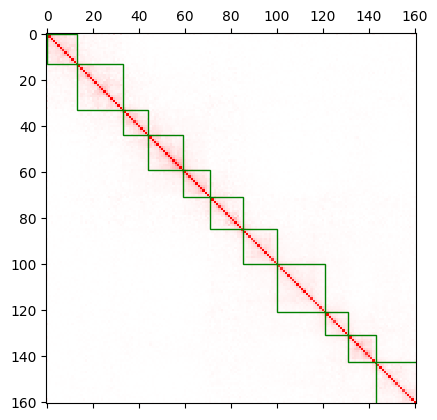

In [81]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, communities)

In [11]:
import pandas as pd

In [12]:
arrow_tads = pd.read_csv("50000_blocks.bedpe", sep='\s+').iloc[1:,:].reset_index(drop=True)

In [48]:
starts = arrow_tads[(arrow_tads["#chr1"] == '4') & (arrow_tads["chr2"] == '4')]["x1"].astype("int")/RESOLUTION
ends = arrow_tads[(arrow_tads["#chr1"] == '4') & (arrow_tads["chr2"] == '4')]["x2"].astype("int")/RESOLUTION

st = starts[starts<100].reset_index(drop=True).astype('int')
en = ends[starts<100].reset_index(drop=True).astype('int')

In [51]:
arrow_comms = []
for i in range(len(st)):
    arrow_comms.append([j for j in range(st[i], en[i])])

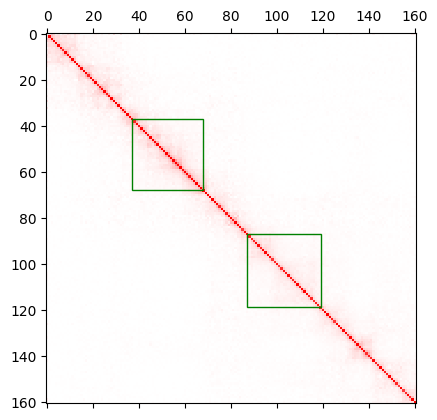

In [53]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, arrow_comms)

In [34]:
def communities_to_coords(communities, resolution):
    coords = []
    for community in communities:
        coords.append([community[0]*resolution, community[-1]*resolution])
    return coords
        

In [35]:
communities_to_coords(communities, RESOLUTION)

[[0, 500000],
 [550000, 950000],
 [1000000, 1250000],
 [1300000, 1600000],
 [1650000, 2150000],
 [2200000, 2900000],
 [2950000, 3550000],
 [3600000, 3600000],
 [3650000, 4200000],
 [4250000, 4900000],
 [4950000, 5600000],
 [5650000, 5650000],
 [5700000, 5900000],
 [5950000, 6300000],
 [6350000, 7050000],
 [7100000, 7650000],
 [7700000, 8000000]]

In [82]:
%%timeit
ModLouvien(numpy_matrix_chr4, 1.5).run(verbose=False) ## with multiprocessing

10.9 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%%timeit
ModLouvien(numpy_matrix_chr4, 1.5).run(verbose=False) ## no multiprocessing

14.2 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Gamma comparisons

In [13]:
communities_1_5 = ModLouvien(numpy_matrix_chr4, 1.5, seed=12).run(verbose=False)
communities_0_5 = ModLouvien(numpy_matrix_chr4, 0.5, seed=12).run(verbose=False)
communities_1 = ModLouvien(numpy_matrix_chr4, 1, seed=12).run(verbose=False)
communities_15 = ModLouvien(numpy_matrix_chr4, 15, seed=12).run(verbose=False)
communities_0_1 = ModLouvien(numpy_matrix_chr4, 0.1, seed=12).run(verbose=False)

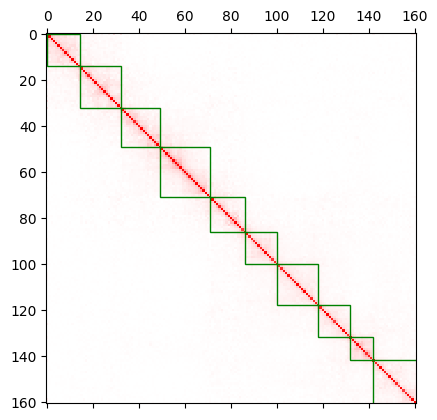

In [14]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, communities_1_5) # gamma=1.5

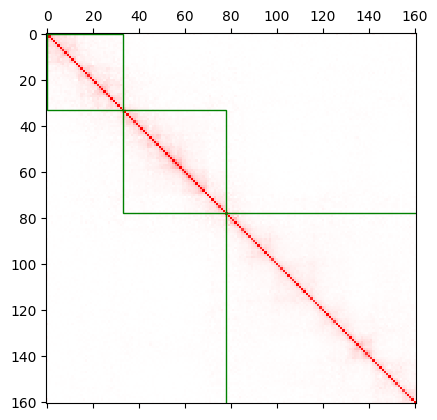

In [15]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, communities_0_5) # gamma=0.5

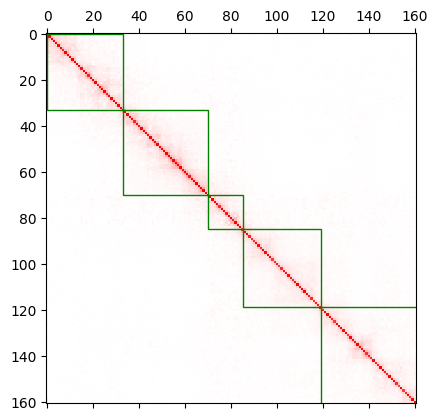

In [16]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, communities_1) # gamma=1

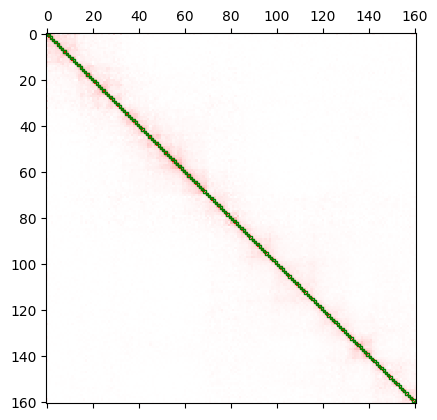

In [17]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, communities_15) # gamma=15

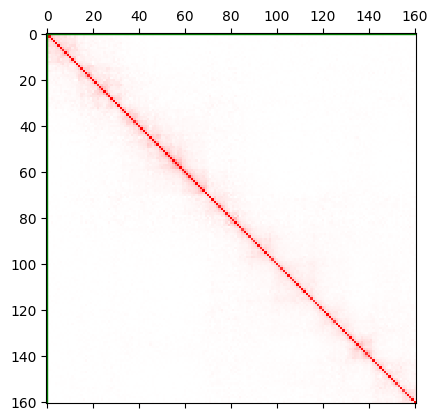

In [18]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, communities_0_1) # gamma=0.1